<a href="https://colab.research.google.com/github/jesperiksson/struc-mon/blob/master/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Provide a path to the directory of the data files to use

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


All of the settings

In [0]:
use = 'MLP'
name = 'onlineMLP'
#####################

architecture = {
    'name' :use + name,
    'active_sensors' : ['90'],
    'predict' : 'accelerations', # accelerations or damage
    'data_path' : '/content/drive/My Drive/KTH/Examensarbete/struc-mon (kopia)/our_measurements3/e90',
    'random_mode' : 'test' # test or debug
    }
sensor_dict = {}
for i in range(len(architecture['active_sensors'])):
    sensor_dict.update({
        architecture['active_sensors'][i] : i
        })
architecture.update({
    'sensors' : sensor_dict
    })
architecture.update({
        'model' : 'two_layer',
        # Net configuaration
        'n_units' : {'first' : 500, 'second' : 250},
        'bias' : True,
        'n_pattern_steps' : 1000, # Kan ändras
        'n_target_steps' : 100,
        'pattern_delta' : 40,
        # Sensor parameters
        'pattern_sensors' : ['90'],
        'target_sensor' : '90',
        'target_sensors' : ['90'],
        # Training parameters
        'batch_size' : 10,
        'data_split' : {'train':60, 'validation':20, 'test':20}, # sorting of data 
        'mode' : '1',
        'delta' : 1, # Kan ändras
        'Dense_activation' : 'tanh',
        'early_stopping' : True,
        'epochs' : 200,
        'learning_rate' : 0.001, # 0.001 by default
        'min_delta' : 0.01,
        'preprocess_type' : 'data',
        'patience' : 50,
        # Data interval
        'from' : 0,
        'to' : -1,
        # Model saving
        'save_periodically' : True,
        'save_interval' : 1, # Number of series to train on before saving
        'model_path' : '/content/drive/My Drive/KTH/Examensarbete/struc-mon (kopia)/models/',
        # Classification
        'limit' : 0.9
    })

This function creates instances of the `DataBatch` class, where each batch contains one data series, a.k.a one passage. There are subclasses `data`, `peaks`, `extrema` and `frequency`. Data contains the entire series, peaks contains all peak accelerations, extrema contains all local and global extreme values and frquency contains a frequency spectrum. 

In [0]:
import os
import random
import numpy as np
import h5py
import scipy as sp
import scipy.signal
def fit_to_NN(
        data_split, 
        path, 
        healthy_percentage, 
        arch):
    
    types = arch['preprocess_type']
    paths = {}

    for i in range(len(arch['active_sensors'])):
        paths.update(
            {arch['active_sensors'][i] : path+'s'+arch['active_sensors'][i]+'/'})
    if arch['random_mode'] == 'debug':
        seed = 1
    elif arch['random_mode'] == 'test':
        seed = random.randint(0,10000)
    file_list = os.listdir(paths[arch['active_sensors'][0]])
    file_list.sort()
    random.Random(seed).shuffle(file_list)

    speeds = np.empty([len(file_list)])
    for i in range(len(file_list)):
        if len(file_list[i]) == 9:
            speeds[i] = int(file_list[i][0:5])
        elif len(file_list[i]) == 10:
            speeds[i] = int(file_list[i][0:6])
        else: 
            print('error')
    normalized_speeds = (speeds-min(speeds))/(max(speeds)-min(speeds))

    n_files = len(file_list)
    data_stack = {}
    preprocess_stack = {}
    peaks_stack = {}
    frequency_stack = {}
    extrema_stack = {}
    start = arch['from']
    to = arch['to']
    diff = to-start
    for i in range(n_files):
        data = [None]*len(paths)
        for j in range(len(paths)):
            mat = h5py.File(paths[arch['active_sensors'][j]] + file_list[i], 'r')
            data[j] = mat.get('acc')[1,start:to]

        if i/n_files < (data_split['train']/100):
            category = 'train'
        elif i/n_files > (data_split['validation']/100) and i/n_files < ((data_split['train']+data_split['validation'])/100):
            category = 'validation'
        else:
            category = 'test'
        if 'data' in types:
            data_stack.update({
                'batch'+str(i) : DataBatch(data,
                                 i,
                                 speeds[i]/1000,
                                 normalized_speeds[i],
                                 category,
                                 healthy_percentage)
                                })
        if 'frequency' in types:
            frequency_stack.update({
                'batch'+str(i) : frequencySpectrum(data,
                                 i,
                                 speeds[i]/1000,
                                 normalized_speeds[i],
                                 category,
                                 healthy_percentage)
                                })
        if 'peaks' in types:
            peaks_stack.update({
                'batch'+str(i) : peaks(data,
                                 i,
                                 speeds[i]/1000,
                                 normalized_speeds[i],
                                 category,
                                 healthy_percentage)
                                })
        if 'extrema' in types:
            extrema_stack.update({
            'batch'+str(i) : extrema(data,
                             i,
                             speeds[i]/1000,
                             normalized_speeds[i],
                             category,
                             healthy_percentage)
                            })

    preprocess_stack.update({
        'data' : data_stack,
        'frequency' : frequency_stack,
        'peaks' : peaks_stack,
        'extrema' : extrema_stack
        })    

    return preprocess_stack

`DataBatch` base class. `__init__` function creates instance with all the useful attributes. 

In [0]:
class DataBatch():
    def __init__(self, data, batch_num, speed, normalized_speed, category, damage_state):
        self.data = np.array(data)
        self.unnormalized_data = np.array(data)
        for i in range(np.shape(data)[0]):
            self.data[i,:] = self.data[i,:]/max(abs(self.data[i,:]))
        #self.data = preprocessing.normalize(self.data)
        self.sensors = np.shape(data)[0]
        self.batch_num = batch_num
        self.category = category
        self.n_steps = np.shape(self.data)[1]
        self.speed = {'km/h' : speed, 'm/s' : (speed*3.6/10)}
        self.normalized_speed = normalized_speed
        self.damage_state = damage_state
        self.normalized_damage_state = damage_state/100
        self.timestep = 0.001
        self.timesteps = np.arange(0, self.n_steps, 1)
        self.steps = [None]*self.sensors
        self.indices = [None]*self.sensors
        self.delta = [None]*self.sensors
        for i in range(self.sensors):
            self.steps[i] = self.n_steps

The two modes of dividing the available data into sets. Which one is used is decided by the `'mode'` parameter below training parameters in `architecture`. 

`data_split_mode1` takes the available healthy data assigned for validation and test according to the `'data_split'` parameter (below training parameters in architecture) and puts it aside. (Usually it is `{'train':60, 'validation':20, 'test':20}`).
Furthermore, it sets all available unhealthy data as test data.

`data_split_mode2` divides all available data, both healthy and unhealthy according to the `'data_split'` parameter. 

In [0]:
def data_split_mode2(a):
    series_stack = {}
    damage_dir_list = os.listdir(a['path'])
    for j in range(len(damage_dir_list)):
        series_stack.update({
            damage_dir_list[j] : fit_to_NN(
                a['data_split'],
                a['data_path']+'/'+damage_dir_list[j]+'/', 
                int(damage_dir_list[j][:-1]),
                a)
            })
    return series_stack

def data_split_mode1(a):
    series_stack = {}
    damage_dir_list = os.listdir(a['data_path'])
    for j in range(len(damage_dir_list)):
        if damage_dir_list[j] == '100%':
            series_stack.update({
                damage_dir_list[j] : fit_to_NN(
                    a['data_split'],
                    a['data_path']+'/'+damage_dir_list[j]+'/',
                    int(damage_dir_list[j][:-1]),
                    a)
                })
        else:
            series_stack.update({
                damage_dir_list[j] : fit_to_NN(
                    {'train' : 0, 'validation' : 0, 'test' : 100},
                    a['data_path']+'/'+damage_dir_list[j]+'/',
                    int(damage_dir_list[j][:-1]),
                    a)
                })
    return series_stack

The aforementioned `peaks` class. The `self.timesteps` attribute contains the indices of the timesteps where the peak accelerations occur. 

In [0]:
class peaks(DataBatch):
    def __init__(self, data, batch_num, speed, normalized_speed, category, damage_state):  
        super().__init__(data, batch_num, speed, normalized_speed, category, damage_state)
        self.peaks = [None]*self.sensors
        for i in range(self.sensors):
            self.indices[i], properties = sp.signal.find_peaks(
                self.data[i], 
                height = None, 
                threshold = None,
                distance = 2,
                prominence = None,
                width = None)
            self.peaks[i] = self.data[i][self.indices[i]]
            
            delta = np.diff(self.indices[i])
            self.delta[i] = delta/max(delta)
        self.n_steps = np.shape(self.peaks[0])[0] # overwrite data
        self.timesteps = self.indices[0]
        self.data = self.peaks 

Piece of code which activates the chosen split function.

In [0]:
    if architecture['mode'] == '1':
        series_stack = data_split_mode1(architecture)
        '''
        This is the normal case where all available data is divided into train/ test/ validation
        '''

    elif architecture['mode'] == '2':
        series_stack = data_split_mode2(architecture)
        '''
        This is special case where only healthy data is used for training and 
        all damaged data is used for testing.
        '''
    #series_stack

Have a look at the data we're working with:

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


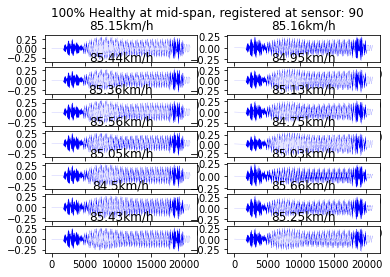

In [26]:
import matplotlib.pyplot as plt
def plot_batch(stack, arch, plot_sensor = '90'): 
    stack = stack[arch['preprocess_type']]
    side = min(int(np.floor(np.sqrt(len(stack)))),7)
    fig, axs = plt.subplots(7, 2, constrained_layout=True)
    k = 0
    for i in range(7):            
        for j in range(2):        
            series = stack['batch'+str(k)]
            axs[i][j].plot(series.timesteps, series.unnormalized_data[arch['sensors'][plot_sensor],:], 'b', linewidth=0.1)
            #plt.plot(stack[key].peaks_indices[sensor], stack[key].peaks[sensor], 'ro', linewidth = 0.4)
            axs[i][j].set_title(str(series.speed['km/h'])+'km/h')
            #plt.set_xlabel('timesteps')
            #plt.set_ylabel('acceleration')
            k += 1
        k += 1
    plt.suptitle(str(series.damage_state)+'% Healthy at mid-span, registered at sensor: '+plot_sensor)
    name = 'E'+str(series.damage_state)+'_d90_s'+plot_sensor+'.png'
    #print(name)
    #plt.savefig(name)
    plt.show()

    return
DataBatch.plot_batch = plot_batch
DataBatch.plot_batch(series_stack['100%'], architecture)

Some necessary modules and objects. It is important to use the tensorflow implementation af the Keras API.

In [0]:
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.models import Model, model_from_json
from tensorflow.python.keras.layers import Input, Dense, concatenate, Activation
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras import metrics, regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.python.keras import backend

`NeuralNet` class. Most importantly contains the `self.model` attribute. The `model_dict` dictionary variable must be updated once a new model architecture is added. 

In [0]:
class NeuralNet():
    def __init__(self,
                 arch,
                 name,
                 existing_model = False):

        self.arch = arch
        self.name = name
        self.target_sensor = self.arch['sensors'][self.arch['target_sensor']]
        self.pattern_sensors = self.arch['sensors'][self.arch['pattern_sensors'][0]]
        self.sensor_to_predict = arch['sensors'][arch['target_sensor']]
        if arch['early_stopping'] == True:
            self.early_stopping = [keras.callbacks.EarlyStopping(
                monitor='loss',
                min_delta=arch['min_delta'], 
                patience=arch['patience'],
                verbose=1,
                mode='auto',
                restore_best_weights=True)]

        else:
            self.early_stopping = None
        self.existing_model = existing_model
        self.n_sensors = len(arch['sensors'])    
        model_dict = {
            'single_layer' : set_up_model3(arch),
            'two_layer' : set_up_model5(arch)
            }     
        if self.existing_model == False:
            model = model_dict[arch['model']]

        elif self.existing_model == True:
            model_path = arch['model_path']+self.arch['name']+'.json'
            weights_path = arch['model_path']+self.arch['name']+'.h5'
            json_file = open(model_path)
            loaded_model_json = json_file.read()
            json_file.close()
            loaded_model = model_from_json(loaded_model_json)
            loaded_model.load_weights(weights_path)
            model = loaded_model
            print('\n Loaded model: ', name)
        else:
            raise Error
        optimizer = keras.optimizers.Adam(
            learning_rate = arch['learning_rate'],
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-07,
            amsgrad=False)
        model.compile(
            optimizer=optimizer, 
            loss=rmse, 
            metrics=[rmse])
        plot_model(model, to_file=name+'.png')
        model.summary()
        self.model = model
        self.score = None
        self.loss = [None]

The training method for the `NeuralNet` class. As arguments it requires firstly a `NeuralNet` object and secondly a dictionary of training series. The dictionary shall contain keys which indicate the damage state and values which, in turn, are also dictionaries. These dictionaries contains key-value pairs where the different data manipulations (i.e. data, peaks, extrema and frequency) are keys and the corresponding series stacks are the values. Finally, the series stacks are dictionaries where all the `DataBatch` objects have keys `batch0`, `batch1`, ... and so forth.
I know this is a bit convoluted but it is what allows the entire program to be maniuplated via the `architecture` variable. 

The training process uses one series at a time to train. It is implemented this way because of hardware limitations on the machine this program was initially developed on but for this Colab implementation it would make more sense to put all available data into one large training set. 

The `x` and `y` arguments are provided as dictionaries since different models might use different inputs. This way the model will only use the variables it requests. 

The model is saved intermediatley if the `'save_periodically'` below Model Saving in `architecture` is set to `True` at intervals specified by `'save_interval'`.

In [0]:
    def train(self, series_stacks):
        tic = time.time()
        self.history = [None]
        self.loss = [None]
        self.val_loss = [None]
        keys = list(series_stacks.keys())
        for h in range(len(keys)):
            series_stack = series_stacks[keys[h]]
            print('\nTraining on ', keys[h],'% healthy data.\n')
            print('\n Number of series being used for training:', len(series_stack[self.arch['preprocess_type']]), '\n')
            for i in range(len(series_stack[self.arch['preprocess_type']])):
                series = series_stack[self.arch['preprocess_type']]['batch'+str(i)]
                if series.category == 'train' or series.category == 'validation':
                    print('\nFitting series: ', i, ' out of:', len(series_stack[self.arch['preprocess_type']]))
                    X, Y = generator(self, series)
                    patterns = {
                        'speed_input' : np.array([series.normalized_speed]),
                        'damage_input' : series.normalized_damage_state}
                    for j in range(len(self.arch['active_sensors'])):
                        patterns.update({
                            'accel_input_'+str(self.arch['pattern_sensors'][j]) : X # Ange vilken
                        })
                    targets = {
                        'accel_output_'+str(self.arch['pattern_sensors'][j]) : Y,
                        'damage_state_output' : series.normalized_damage_state
                        }           
                    history = self.model.fit(
                        x = X,#patterns,
                        y = Y,#targets, 
                        batch_size = self.arch['batch_size'],
                        epochs=self.arch['epochs'], 
                        verbose=1,
                        callbacks=self.early_stopping, #self.learning_rate_scheduler],
                        validation_split = self.arch['data_split']['validation']/100,
                        shuffle = True)
                    self.history.append(history)
                    self.loss.extend(history.history['loss'])
                    self.val_loss.extend(history.history['val_loss'])  
                    if self.arch['save_periodically'] == True and i % self.arch['save_interval'] == 0:
                        save_model(self.model,self.name)  
        self.model.summary()
        self.toc = np.round(time.time()-tic,1)
        print('Elapsed time: ', self.toc)
        return
    NeuralNet.train = train

The Tensorflow and NumPy respective implementations of the Root mean square error function. 

In [0]:
def rmse(true, prediction):
    return backend.sqrt(backend.mean(backend.square(prediction - true), axis=-1))
def rmse_np(true, prediction):
    return np.sqrt(np.mean(np.square(prediction - true), axis=-1))

Method for evaluating a model. It requires the same arguments as the `train ` method. The returned `results` contains lists that are used to plot the results. The model score is defined as the Root mean square error for the model on a single series, and should in general be the same as the models' loss function. 

In [0]:
    def evaluation(self, series_stack):
        scores = []
        speeds = []
        damage_states = []
        for i in range(len(series_stack[self.arch['preprocess_type']])):
            series = series_stack[self.arch['preprocess_type']]['batch'+str(i)]
            if series.category == 'test':
                X, Y = generator(self, series)
                score = self.model.evaluate(
                    x = X,
                    y = Y,
                    batch_size = self.arch['batch_size'],
                    verbose = 1,
                    return_dict = True)
                speeds.extend([series.speed['km/h']])
                scores.extend([score['rmse']])
                damage_states.extend([series.damage_state])
            
        results = {
            'scores' : scores[:],
            'speeds' : speeds[:],
            'steps' : len(speeds[:]),
            'damage_state' : damage_states[:]
        }
        return results
    NeuralNet.evaluation = evaluation

The generator function takes a series via the `batch` argument and reshapes it into the form that fits the model. The form is specified via the `'n_pattern_steps'`, `'n_target_steps'` and `'pattern_delta'` arguments in `architecture`. 

Here is an example of what `generator` returns if `'n_pattern_steps'` is 4, `'n_target_steps'` is 2 and `'pattern_delta'` is 3. (Given that the total number of acceleration signals $m$ in the series happens to line up with the configuration. If it doesn't the last few acceleration signals are omitted.)

$series = (a_{1}, a_{2}, ..., a_{m})$

$pattern_1 = (a_{1}, a_{2}, a_{3}), target_1 = (a_{4}, a_{5})$

$pattern_2 = (a_{4}, a_{5}, a_{6}), target_2 = (a_{7}, a_{8})$

$pattern_n = (a_{m-4}, a_{m-3}, a_{m-2}), target_n = (a_{m-1}, a_{m})$ 

In [0]:
def generator(self, batch):
    steps = get_steps(self, batch)
    #print(steps)
    X = np.empty([steps,self.arch['n_pattern_steps'], len(self.arch['pattern_sensors'])])
    Y = np.empty([steps,self.arch['n_target_steps']])
    for j in range(len(self.arch['pattern_sensors'])):     
        for k in range(steps):    
            pattern_start = k*self.arch['pattern_delta']
            pattern_finish = k*self.arch['pattern_delta']+self.arch['delta']*self.arch['n_pattern_steps']
            target_start = k*self.arch['pattern_delta']+self.arch['delta']*self.arch['n_pattern_steps'] # +1?
            target_finish = k*self.arch['pattern_delta']+self.arch['delta']*(self.arch['n_pattern_steps']+self.arch['n_target_steps'])
            X[k,:,j] = batch.data[j][pattern_start:pattern_finish]
            Y[k,:] = batch.data[j][target_start:target_finish]
    return X, Y

`get_steps` calculates the number $n$ in the example above, i.e. the number of targets and patterns that fit into a series.l

In [0]:
def get_steps(self, series):
    steps = int(
        np.floor(
            (series.n_steps-(self.arch['n_pattern_steps']+self.arch['n_target_steps']))/self.arch['pattern_delta']
        )
    )
    return steps  

Utility function for saving the model. The save location is specified in `'model_save_path'` in `architecture`

In [0]:
def save_model(model):
    model_json = model.to_json()
    with open(model.arch['model_path']+model.arch['name']+'.json', 'w') as json_file:
        json_file.write(model_json)
        # serialize weights to HDF5
    model.save_weights(model.arch['model_path']+name+'.h5')
    print('Saved model:', name)

Function for plotting the evolution of the train and validation losses during training. 

In [0]:
def plot_loss(self, name):
    plt.figure()
    plt.plot(range(len(self.loss)), self.loss, 'bo', label='Training loss', linewidth=0.3)
    plt.plot(range(len(self.val_loss)), self.val_loss, 'ro', label='Validation loss', linewidth=0.3)
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss - RMSE')
    plt.legend()
    plt.savefig(fname = name+'_loss_plot.png')
    plt.show() 

Sets up this model: #image of model

In [0]:
def set_up_model(arch):
  return

Method for creating a forecast. The Model makes a prediction on an input of size `'n_pattern_steps'`. This prediction is appended onto said input, the `'n_pattern_steps'` first steps are removed and the result is fed back into the model. After some steps the entire input consists of predicted values. This is of course a much more difficult task for the model than to just produce predictions. 

In [0]:
def forecast(machines, manual):
    # Machines
    machine_keys = list(machines.keys())
    # Shortcuts
    machine = machines[machine_keys[0]]
    delta = machine.arch['delta']
    n_pattern_steps = machine.arch['n_pattern_steps']
    n_target_steps = machine.arch['n_target_steps']
    # Series
    key = 'batch'+str(manual['series_to_predict']%len(manual['stack'][machine.arch['preprocess_type']]))
    n_steps = manual['stack'][machine.arch['preprocess_type']][key].n_steps
    series = manual['stack'][machine.arch['preprocess_type']][key]
    n_series = int((n_steps-n_pattern_steps)/n_target_steps)
    # Initial
    initial_indices = np.arange(0,delta*n_pattern_steps,delta)
    patterns = {}
    for i in range(len(machine.arch['pattern_sensors'])):
        patterns.update({ 
        'accel_input_'+machine.arch['pattern_sensors'][i] : 
            np.reshape(
                series.data[machine.sensor_to_predict][initial_indices], 
                [1,machine.arch['n_pattern_steps']]
            )
        })
    forecasts = patterns.copy()
    evaluation = {}
    for i in range(n_series+1):
        old_patterns = patterns.copy()
        for j in range(len(machine_keys)):
            machine = machines[machine_keys[j]] # Pick machine
            prediction = machine.model.predict(
                old_patterns,
                batch_size = 1, 
                verbose=0,
                steps = 1) # Make prediction with machine
            pattern = patterns['accel_input_'+machine.arch['pattern_sensors'][j]] # Extract pattern
            pattern = np.delete(pattern,np.s_[0:n_target_steps:delta],1) # Remove first entty
            pattern = np.hstack([pattern,prediction]) # Add prediciton last
            patterns.update({
                'accel_input_'+machine.arch['pattern_sensors'][j] : pattern
                }) # Update patterns dict
            forecast = forecasts['accel_input_'+machine.arch['pattern_sensors'][j]] #Extract forecast
            if i == n_series: # Edge case for last bit                   
                forecast = np.hstack(
                    [forecast,
                    prediction[:,:n_steps%(n_series*n_target_steps+n_pattern_steps)]]
                    ) # Update forecast
            else:
                forecast = np.hstack([forecast,prediction]) # Update forecast
            forecasts.update({
                'accel_input_'+machine.arch['pattern_sensors'][j] : forecast
                }) # Update forecasts dict
    score = rmse_np(
        series.data[j][n_pattern_steps:], 
        forecasts['accel_input_'+machine.arch['pattern_sensors'][j]][0][n_pattern_steps:])
    speed = series.speed['km/h']
    damage_state = series.damage_state
    return forecasts, (score, speed, damage_state)
NeuralNet.forecast = forecast

In [0]:
def set_up_model3(arch):
    
    accel_input = Input(
        shape=(arch['n_pattern_steps'], ),
        name='accel_input_'+arch['target_sensor'])

    hidden_1 = Dense(
        arch['n_units']['first'],
        activation = arch['Dense_activation'],
        use_bias = arch['bias'],
        name = 'hidden_layer')(accel_input)

    output = Dense(
        arch['n_target_steps'], 
        activation='tanh', 
        name='acceleration_output')(hidden_1) 

    model = Model(inputs = accel_input, outputs = output)
    return model

In [0]:
def set_up_model5(arch):
    
    accel_input = Input(
        shape=(arch['n_pattern_steps'], ),
        name='accel_input_90')

    hidden_1 = Dense(arch['n_units']['first'],
                     activation = arch['Dense_activation'],
                     use_bias=arch['bias'])(accel_input)

    hidden_2 = Dense(arch['n_units']['second'],
                     activation = arch['Dense_activation'],
                     use_bias=arch['bias'])(hidden_1)

    output = Dense(arch['n_target_steps'], activation='tanh', name='acceleration_output')(hidden_2) 
    model = Model(inputs = accel_input, outputs = output)
    return model

Checking if there already is a trained model with the specified name. If so that model is loaded, if not a new one is initialized and trained. 

In [0]:

name = architecture['name']
try:
    f = open(architecture['model_path']+name+'.json')
    machine_stack.update({
        name : NeuralNet(architecture,
              name,
              existing_model = True)
    })
except IOError:    
    machine_stack.update({
        name : NeuralNet(architecture,
              name,
              existing_model = False)
    })
    NeuralNet.train(machine_stack[name], series_stack)  
    save_model(machine_stack[name].model, name)
    plot_loss(machine_stack[name], name)

This function plots RMSE (y-axis) versus speed (x-axis), and colors the datapoints according to their damage state. This makes it easy to see if the model performs better on healthy or unhealthy data, or if there is no difference. 

In [0]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
def plot_performance(score_stack, a, pod): # pod = prediction or forecast
    cmap = plt.cm.rainbow
    norm = colors.Normalize(vmin=33,vmax=100)
    percentage_keys = list(score_stack)
    for i in range(len(percentage_keys)): # Iterates over percentages
        for j in range(len(score_stack[percentage_keys[i]]['speeds'])):
            plt.plot(score_stack[percentage_keys[i]]['speeds'][j], 
                     score_stack[percentage_keys[i]]['scores'][j], 
                     color=cmap(norm(score_stack[percentage_keys[i]]['damage_state'][j])), 
                     marker='o')
    plt.xlabel('Speed [km/h]')
    plt.ylabel('Root Mean Square Error')
    plt.title('Sample scores for '+pod+' at sensor ' + str(a['target_sensor']))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = plt.colorbar(sm)
    cbar.set_label('Young\'s modulus percentage', rotation=270)
    plt.legend()
    plt.savefig(fname = a['name']+pod+'_performance_plot.png')
    plt.show()
plot_performance(score_stack, architecture, 'prediction')

Print the prediction on the specified series. 

In [0]:
prediction_manual = {
    'series_to_predict' : 12,
    'stack' : series_stack['100%']
}
plot_forecast(forecast(machine_stack['name'], prediction_manual), prediction_manual, architecture)

Similarly to how the `evaluation` function evaluate each data series on the predictions made on that series

In [0]:
    prediction_score = {}
    for i in range(len(keys)):
        #print(series_stack[keys[i]])
        scores = []
        speeds = []
        damage_states = []
        for j in range(len(series_stack[keys[i]][architecture['preprocess_type']])):
            if series_stack[keys[i]][architecture['preprocess_type']]['batch'+str(j)].category == 'test':
                prediction_manual = {
                    'series_to_predict' : j,
                    'stack' : series_stack[keys[i]]
                }
                #prediction = NeuralNet.prediction(machine_stack[name], prediction_manual)
                #plot_prediction(prediction, prediction_manual, use)
                forecast, tup = NeuralNet.forecast(machine_stack, prediction_manual)
                scores.extend([tup[0]])
                speeds.extend([tup[1]])
                damage_states.extend([tup[2]])
            else:
                continue
        prediction_score.update({
            keys[i] : {'scores' : scores, 'speeds' : speeds, 'damage_state' : damage_states}           
            })